In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import json
import fpfs
import galsim
import numpy as np
import matplotlib.pylab as plt
import astropy.io.fits as pyfits
from configparser import ConfigParser
from astropy.visualization import simple_norm

In [32]:
kappa = 0
gamma1 = 0.02
gamma2 = 0

class Stamp(object):
    def __init__(self, coords=None, nn =32, scale = 0.2):
        """ Initialize the 2D stamp object
        Args:
            nn (int):      number of grids on x and y direction
            scale (float): pixel scale in units of arcsec
        """
        if coords is None:
            indX = np.arange(-int(nn/2), int((nn + 1) / 2), 1) * scale
            indY = np.arange(-int(nn/2), int((nn + 1) / 2), 1) * scale
            inds = np.meshgrid(indY, indX, indexing="ij")
            self.coords = np.vstack([np.ravel(_) for _ in inds])
        else:
            self.coords = coords
        self.pixel_values = None
        self.transformed = False
        return
        
    def sample_galaxy(galsim_obj):
        """ Sample the surface density field of a galaxy at the grids
        """
        self.pixel_values = 1.0
        return
    
    def transform_grids(transform_obj):
        self.coords = transform_obj.transform(self.coords)
        self.transformed = True
        return
    
class LensTransform1(object):
    def __init__(self,gamma1, gamma2, kappa):
        """"Initialize the transform object of 2D grids
        Args:
            gamma1 (float):     the first component of lensing shear field
            gamma2 (float):     the second component of lensing shear field
            kappa (float):      the lensing convergence field
        """"
        self.s2l_mat = np.array([[1- kappa - gamma1, -gamma2], [-gamma2, 1 - kappa + gamma1]])
        return
    
    def transform(self, coords)
        return s2l_mat @ coords

In [33]:
coords2

array([[-3.136, -3.136, -3.136, ...,  2.94 ,  2.94 ,  2.94 ],
       [-3.264, -3.06 , -2.856, ...,  2.652,  2.856,  3.06 ]])

In [31]:
coords.shape

(1024, 2)

In [2]:
def prepare_psf(pscale, seeing, psf_type, outdir):
    psffname = os.path.join(outdir, "psf-%d.fits" % (seeing * 100))
    if psf_type.lower() == "moffat":
        psfInt = galsim.Moffat(
            beta=3.5, fwhm=seeing, trunc=seeing * 4.0
        ).shear(e1=0.02, e2=-0.02)
    else:
        raise ValueError("Only support moffat PSF.")
    psfImg = psfInt.drawImage(nx=45, ny=45, scale=pscale)
    psfImg.write(psffname)
    return psfInt

In [3]:
Id = 1
config_name = 'config_sim_gal.ini'
cparser = ConfigParser()
cparser.read(config_name)
simname = cparser.get("simulation", "sim_name")
imgdir = cparser.get("simulation", "img_dir")
infname = cparser.get("simulation", "input_name")
scale = cparser.getfloat("survey", "pixel_scale")
image_nx = cparser.getint("survey", "image_nx")
image_ny = cparser.getint("survey", "image_ny")
assert image_ny == image_nx, "'image_nx' must equals 'image_ny'!"
if "basic" in simname or "small" in simname:
    assert image_nx % 256 == 0, "'image_nx' must be divisible by 256 ."
outdir = os.path.join(imgdir, simname)
if not os.path.exists(outdir):
    os.makedirs(outdir, exist_ok=True)

seeing = cparser.getfloat("survey", "psf_fwhm")
psfInt = prepare_psf(scale, seeing, psf_type="moffat", outdir=outdir)

glist = []
if cparser.getboolean("distortion", "test_g1"):
    glist.append("g1")
if cparser.getboolean("distortion", "test_g2"):
    glist.append("g2")
if len(glist) > 0:
    zlist = json.loads(cparser.get("distortion", "shear_z_list"))
    pendList = ["%s-%s" % (i1, i2) for i1 in glist for i2 in zlist]
else:
    # this is for non-distorted image simulation
    pendList = ["g1-1111"]
shear_value = cparser.getfloat("distortion", "shear_value")



p2List = ["0000", "2222"]
p1List = ["g1"]
pendList = ["%s-%s" % (i1, i2) for i1 in p1List for i2 in p2List]
pp = pendList[0]

2023/08/31 01:56:14 ---  Processing for g1-0000, and shears for four redshift bins are [-0.03 -0.03 -0.03 -0.03].
2023/08/31 01:56:14 ---  Making Basic Simulation. ID: 1


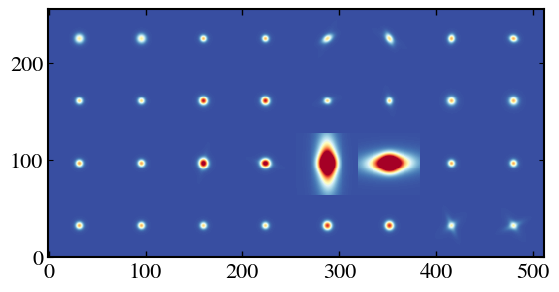

In [4]:
sim_img = fpfs.simutil.make_isolate_sim(
    gal_type="basic",
    psf_obj=psfInt,
    gname=pp,
    seed=Id,
    ny=image_ny//2,
    nx=image_nx,
    scale=scale,
    do_shift=False,
    shear_value=shear_value,
    nrot=2,
)
plt.imshow(sim_img,aspect='equal',cmap='RdYlBu_r',origin='lower',interpolation='None',\
             norm=simple_norm(sim_img,'asinh',asinh_a=0.1,min_cut=-0.01,max_cut=0.8))

2023/08/31 01:56:15 ---  Processing for g1-0000, and shears for four redshift bins are [-0.03 -0.03 -0.03 -0.03].
2023/08/31 01:56:15 ---  Making galaxies with Random Knots.


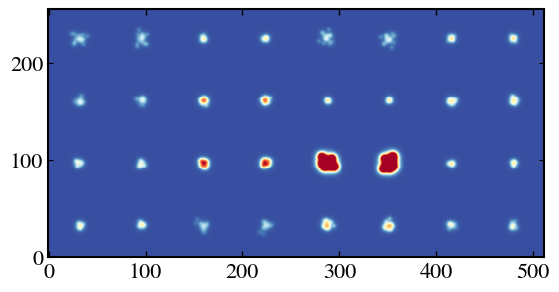

In [5]:
sim_img2 = fpfs.simutil.make_isolate_sim(
    gal_type="random",
    psf_obj=psfInt,
    gname=pp,
    seed=Id,
    ny=image_ny//2,
    nx=image_nx,
    scale=scale,
    do_shift=False,
    shear_value=shear_value,
    nrot=2,
)
plt.imshow(sim_img2,aspect='equal',cmap='RdYlBu_r',origin='lower',interpolation='None',\
             norm=simple_norm(sim_img,'asinh',asinh_a=0.1,min_cut=-0.01,max_cut=0.8))

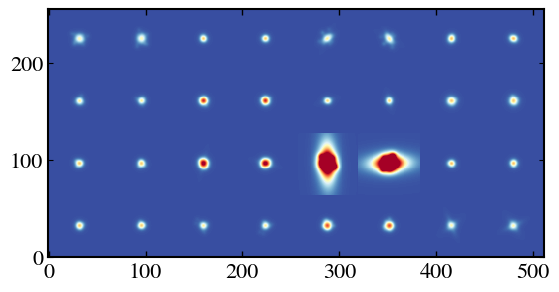

In [6]:
plt.imshow(sim_img*0.70+sim_img2*0.3,aspect='equal',cmap='RdYlBu_r',origin='lower',interpolation='None',\
             norm=simple_norm(sim_img,'asinh',asinh_a=0.1,min_cut=-0.01,max_cut=0.8))